In [95]:
#import the necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, RepeatVector, TimeDistributed

In [2]:
#Read datasets
solar_df = pd.read_csv("solar_sensor_data.csv")
weather_df = pd.read_csv("weather_sensor_data.csv")
solar_A_df = pd.read_csv('solar_sensor_A_location.csv')
solar_B_df = pd.read_csv('solar_sensor_B_location.csv')

weather_A_df = pd.read_csv('weather_sensor_A_location.csv')
weather_B_df = pd.read_csv('weather_sensor_B_location.csv')

In [3]:
weather_A_df.head()

,LOCATION,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,HOUR,MINUTE
0,A,2020-05-15 00:00:00,25.184316,22.857507,0.0,0,0
1,A,2020-05-15 00:15:00,25.084589,22.761668,0.0,0,15
2,A,2020-05-15 00:30:00,24.935753,22.592306,0.0,0,30
3,A,2020-05-15 00:45:00,24.846130,22.360852,0.0,0,45
4,A,2020-05-15 01:00:00,24.621525,22.165423,0.0,1,0


In [4]:
weather_B_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   LOCATION             3259 non-null   object 
 1   DATE_TIME            3259 non-null   object 
 2   AMBIENT_TEMPERATURE  3259 non-null   float64
 3   MODULE_TEMPERATURE   3259 non-null   float64
 4   IRRADIATION          3259 non-null   float64
 5   HOUR                 3259 non-null   int64  
 6   MINUTE               3259 non-null   int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 178.4+ KB


In [5]:
solar_A_df[solar_A_df['DC_POWER']==0.0].value_counts()

LOCATION  DATE_TIME         SENSOR_ID  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD
A         01-06-2020 00:00  sensor 1   0.0       0.0       829.0        6377931.0      1
          19-05-2020 20:00  sensor 1   0.0       0.0       6449.0       6290097.0      1
                            sensor 32  0.0       0.0       6938.0       7201349.0      1
                            sensor 3   0.0       0.0       0.0          7020512.0      1
                            sensor 28  0.0       0.0       6790.0       6217277.0      1
                                                                                      ..
          11-06-2020 21:45  sensor 1   0.0       0.0       5257.0       6450238.0      1
          11-06-2020 21:30  sensor 5   0.0       0.0       5573.0       7806664.0      1
                            sensor 44  0.0       0.0       5671.0       7322687.0      1
                            sensor 43  0.0       0.0       5647.0       6543550.0      1
          31-05-2020 23:45

In [6]:
solar_A_df['DATE_TIME'] = pd.to_datetime(solar_A_df['DATE_TIME'])
solar_B_df['DATE_TIME'] = pd.to_datetime(solar_B_df['DATE_TIME'])

weather_A_df['DATE_TIME'] = pd.to_datetime(weather_A_df['DATE_TIME'])
weather_B_df['DATE_TIME'] = pd.to_datetime(weather_B_df['DATE_TIME'])

C:\Users\User\AppData\Local\Temp\ipykernel_5840\1781902349.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  solar_A_df['DATE_TIME'] = pd.to_datetime(solar_A_df['DATE_TIME'])


In [7]:
merged_A_df= pd.merge(solar_A_df.drop(columns=['LOCATION']),weather_A_df.drop(columns=['LOCATION']),on='DATE_TIME')

In [8]:
merged_B_df= pd.merge(solar_B_df.drop(columns=['LOCATION']),weather_B_df.drop(columns=['LOCATION']),on='DATE_TIME')

In [9]:
merged_A_df.head()

,DATE_TIME,SENSOR_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,HOUR,MINUTE
0,2020-05-15,sensor 1,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0,0,0
1,2020-05-15,sensor 2,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0,0,0
2,2020-05-15,sensor 3,0.0,0.0,0.0,6987759.0,25.184316,22.857507,0.0,0,0
3,2020-05-15,sensor 5,0.0,0.0,0.0,7602960.0,25.184316,22.857507,0.0,0,0
4,2020-05-15,sensor 12,0.0,0.0,0.0,7158964.0,25.184316,22.857507,0.0,0,0


In [10]:
merged_A_df['DATE'] = pd.to_datetime(merged_A_df['DATE_TIME']).dt.date
merged_A_df['TIME'] = pd.to_datetime(merged_A_df['DATE_TIME']).dt.time

merged_B_df['DATE'] = pd.to_datetime(merged_B_df['DATE_TIME']).dt.date
merged_B_df['TIME'] = pd.to_datetime(merged_B_df['DATE_TIME']).dt.time

In [11]:
merged_A_df.shape

(68774, 13)

In [12]:
merged_B_df.describe()

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,HOUR,MINUTE
count,67698,67698.000000,67698.000000,67698.000000,6.769800e+04,67698.000000,67698.000000,67698.000000,67698.000000,67698.000000
mean,2020-06-01 10:44:33.650625024,246.701961,241.277825,3294.890295,6.589448e+08,27.986756,32.607233,0.229204,11.530208,22.517061
min,2020-05-15 00:00:00,0.000000,0.000000,0.000000,0.000000e+00,20.942385,20.265123,0.000000,0.000000,0.000000
25%,2020-05-23 21:00:00,0.000000,0.000000,272.750000,1.996494e+07,24.570349,23.685627,0.000000,6.000000,15.000000
50%,2020-06-01 23:00:00,0.000000,0.000000,2911.000000,2.826276e+08,26.910352,27.433723,0.018554,12.000000,30.000000
75%,2020-06-09 23:30:00,446.591667,438.215000,5534.000000,1.348495e+09,30.912601,40.019036,0.431027,18.000000,45.000000
max,2020-06-17 23:45:00,1420.933333,1385.420000,9873.000000,2.247916e+09,39.181638,66.635953,1.098766,23.000000,45.000000
std,NaN,370.569597,362.112118,2919.448386,7.296678e+08,4.021294,11.226446,0.309365,6.922127,16.764084


z_columns = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

for column in z_columns:
    mean_value = merged_A_df[column].mean()
    std_value = merged_A_df[column].std()
    
    merged_A_df[f'{column}_zscore'] = (merged_A_df[column] - mean_value) / std_value

for column in z_columns:
    mean_value = merged_B_df[column].mean()
    std_value = merged_B_df[column].std()
    
    merged_B_df[f'{column}_zscore'] = (merged_B_df[column] - mean_value) / std_value

In [13]:
#remove zero values rows
merged_A_df_copy  = merged_A_df[merged_A_df['DC_POWER'] != 0.0]

In [14]:
merged_B_df_copy  = merged_B_df[merged_B_df['DC_POWER'] != 0.0]

In [15]:
merged_B_df_copy['AC_POWER'].skew()

0.3934850488364138

In [16]:
#log ttransformation 
merged_B_df_copy['Log_AC_POWER'] = np.log1p(merged_B_df_copy['AC_POWER'])


C:\Users\User\AppData\Local\Temp\ipykernel_5840\146950322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_B_df_copy['Log_AC_POWER'] = np.log1p(merged_B_df_copy['AC_POWER'])


In [17]:
merged_A_df_copy['Log_AC_POWER'] = np.log1p(merged_A_df_copy['AC_POWER'])

C:\Users\User\AppData\Local\Temp\ipykernel_5840\2197622766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_A_df_copy['Log_AC_POWER'] = np.log1p(merged_A_df_copy['AC_POWER'])


In [18]:
merged_B_df_copy.head()

,DATE_TIME,SENSOR_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,HOUR,MINUTE,DATE,TIME,Log_AC_POWER
528,2020-05-15 06:00:00,sensor 4,15.406667,14.860000,0.800000,2.429012e+06,24.742787,24.07723,0.012962,6,0,2020-05-15,06:00:00,2.763800
529,2020-05-15 06:00:00,sensor 6,14.773333,14.246667,0.733333,1.215279e+09,24.742787,24.07723,0.012962,6,0,2020-05-15,06:00:00,2.724361
530,2020-05-15 06:00:00,sensor 7,15.380000,14.840000,1.866667,2.247720e+09,24.742787,24.07723,0.012962,6,0,2020-05-15,06:00:00,2.762538
531,2020-05-15 06:00:00,sensor 8,14.973333,14.440000,1.000000,1.704251e+06,24.742787,24.07723,0.012962,6,0,2020-05-15,06:00:00,2.736962
532,2020-05-15 06:00:00,sensor 9,15.160000,14.633333,0.733333,1.994153e+07,24.742787,24.07723,0.012962,6,0,2020-05-15,06:00:00,2.749405


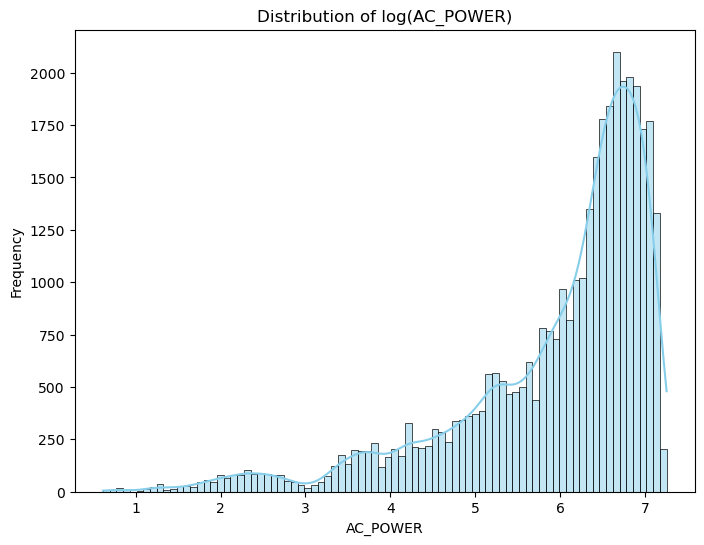

In [109]:
#distributio grapg for AC power --> high skewness
plt.figure(figsize=(8, 6))
sns.histplot(merged_A_df_copy['Log_AC_POWER'], kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of log(AC_POWER)')
plt.xlabel('AC_POWER')
plt.ylabel('Frequency')
plt.show()

- Z-score test is not suitable because both ac_power and log(ac_power) data not normally distributed(skewed).

####  ML Models Training



In [119]:

columns_for_detection = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

loc_A_features = merged_A_df_copy[columns_for_detection]
loc_B_features = merged_B_df_copy[columns_for_detection]

scaler = StandardScaler()
loc_A_scaled = scaler.fit_transform(loc_A_features)
loc_B_feature=scaler.fit_transform(loc_B_feature)


Transformation	        Use Case	                                        Limitation\n
Box-Cox	                Reduces skewness, brings data closer to normality	Requires positive values

In [120]:
# Select columns for anomaly detection (make sure data is numerical)
columns_for_detection = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

# Example: Assuming merged_A_df_copy is your DataFrame
loc_A_features = merged_A_df_copy[columns_for_detection]
loc_B_features =merged_B_df_copy[columns_for_detection]


In [121]:
# Check for any zero or negative values, and apply a small shift if needed
loc_A_features_positive = loc_A_features + 1  # Adding 1 to make all values positive
loc_B_features_positive = loc_B_features+1
# Apply the Box-Cox transformation to each column
loc_A_transformed = loc_A_features_positive.apply(lambda x: stats.boxcox(x)[0])
loc_B_transformed = loc_B_features_positive.apply(lambda x: stats.boxcox(x)[0])
# Now loc_A_transformed contains the transformed features


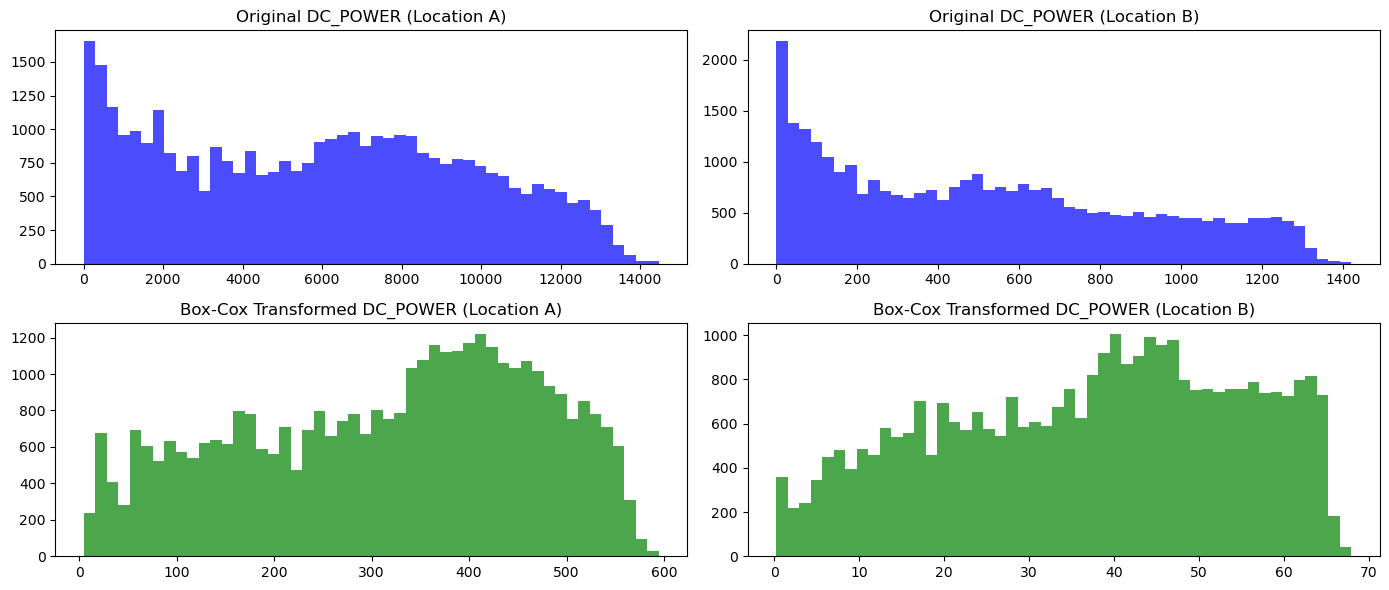

In [122]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

# Original data for loc_A and loc_B
axes[0, 0].hist(loc_A_features['DC_POWER'], bins=50, color='blue', alpha=0.7)
axes[0, 0].set_title('Original DC_POWER (Location A)')

axes[0, 1].hist(loc_B_features['DC_POWER'], bins=50, color='blue', alpha=0.7)
axes[0, 1].set_title('Original DC_POWER (Location B)')

# Transformed data for loc_A and loc_B (Box-Cox transformation)
axes[1, 0].hist(loc_A_transformed['DC_POWER'], bins=50, color='green', alpha=0.7)
axes[1, 0].set_title('Box-Cox Transformed DC_POWER (Location A)')

axes[1, 1].hist(loc_B_transformed['DC_POWER'], bins=50, color='green', alpha=0.7)
axes[1, 1].set_title('Box-Cox Transformed DC_POWER (Location B)')

plt.tight_layout()
plt.show()


In [123]:
# Optionally, scale the transformed data using StandardScaler or MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Scale the Box-Cox transformed data
loc_A_scaled = scaler.fit_transform(loc_A_transformed)
loc_B_scaled = scaler.fit_transform(loc_B_transformed)

# Create the Isolation Forest model
model_A = IsolationForest(contamination=0.05, random_state=42)
model_B = IsolationForest(contamination=0.05, random_state=42)

# Fit the model on the transformed and scaled data
model_A.fit(loc_A_scaled)
model_B.fit(loc_B_scaled)

# Predict anomalies: 1 indicates normal, -1 indicates anomaly
merged_A_df_copy['anomaly'] = model_A.predict(loc_A_scaled)
merged_B_df_copy['anomaly'] = model_B.predict(loc_B_scaled)

# Convert anomalies to a boolean flag (True = Anomaly, False = Normal)
merged_A_df_copy['anomaly'] = merged_A_df_copy['anomaly'] == -1
merged_B_df_copy['anomaly'] = merged_B_df_copy['anomaly'] == -1
# Display the anomalies
print(merged_B_df_copy[['DATE_TIME', 'DC_POWER', 'anomaly']].tail())


                DATE_TIME   DC_POWER  anomaly
68307 2020-06-17 18:30:00  79.000000    False
68308 2020-06-17 18:30:00  75.714286    False
68309 2020-06-17 18:30:00  77.428571    False
68310 2020-06-17 18:30:00  74.857143    False
68311 2020-06-17 18:30:00  77.714286    False


C:\Users\User\AppData\Local\Temp\ipykernel_5840\1025004037.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_A_df_copy['anomaly'] = model_A.predict(loc_A_scaled)
C:\Users\User\AppData\Local\Temp\ipykernel_5840\1025004037.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_B_df_copy['anomaly'] = model_B.predict(loc_B_scaled)
C:\Users\User\AppData\Local\Temp\ipykernel_5840\1025004037.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [160]:
print(merged_B_df_copy[['DATE_TIME', 'DC_POWER', 'anomaly']].head())

              DATE_TIME   DC_POWER  anomaly
528 2020-05-15 06:00:00  15.406667    False
529 2020-05-15 06:00:00  14.773333    False
530 2020-05-15 06:00:00  15.380000    False
531 2020-05-15 06:00:00  14.973333    False
532 2020-05-15 06:00:00  15.160000    False


In [163]:
# Count of True values
true_count_A = merged_A_df_copy['anomaly'].sum()
true_count_B = merged_B_df_copy['anomaly'].sum()

# Count of False values
false_count_A = len(merged_A_df_copy) - true_count_A
false_count_B = len(merged_B_df_copy) - true_count_B

print("True Count for Location A:", true_count_A)
print("False Count for Location A:", false_count_A)
print("True Count for Location B:", true_count_B)
print("False Count for Location B:", false_count_B)

True Count for Location A: 1842
False Count for Location A: 34981
True Count for Location B: 1602
False Count for Location B: 30434


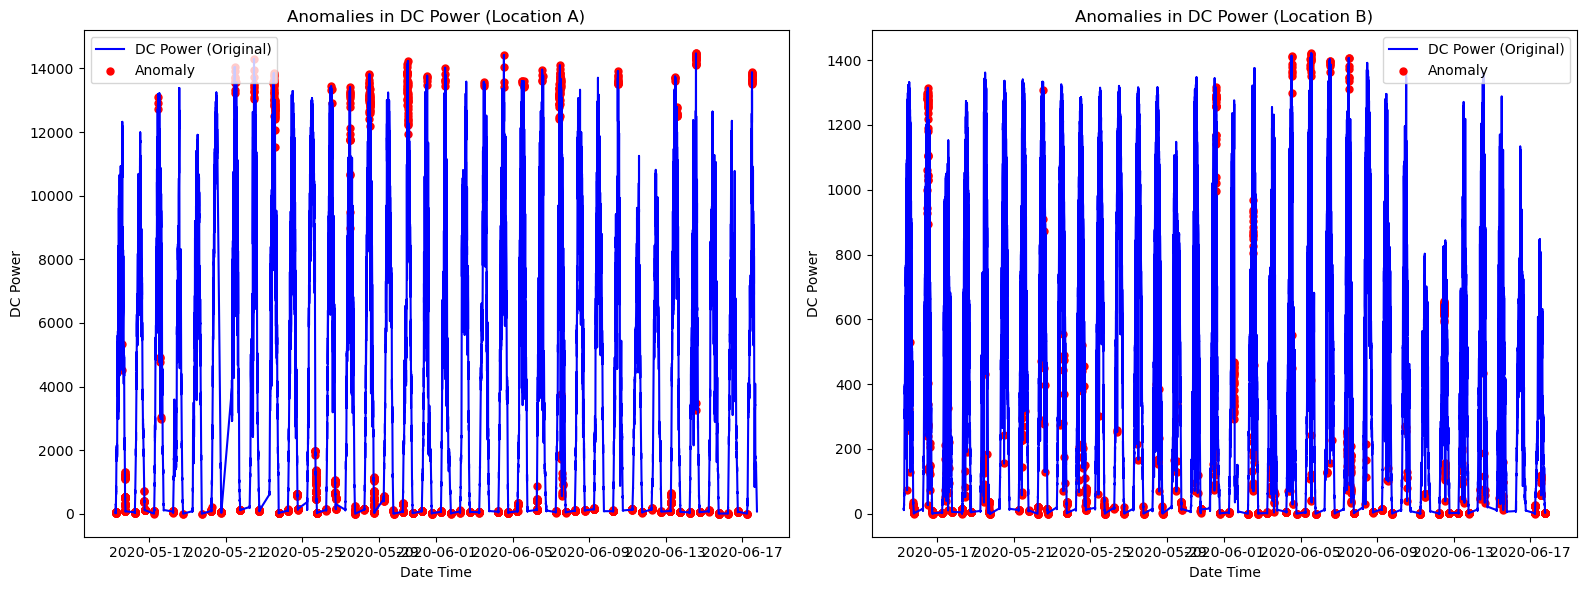

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for merged_A_df_copy
axes[0].plot(merged_A_df_copy['DATE_TIME'], merged_A_df_copy['DC_POWER'], label='DC Power (Original)', color='blue')
axes[0].scatter(merged_A_df_copy['DATE_TIME'][merged_A_df_copy['anomaly']], 
                 merged_A_df_copy['DC_POWER'][merged_A_df_copy['anomaly']], 
                 color='red', label='Anomaly', s=25)
axes[0].set_xlabel('Date Time')
axes[0].set_ylabel('DC Power')
axes[0].set_title('Anomalies in DC Power (Location A)')
axes[0].legend()

# Plot for merged_B_df_copy
axes[1].plot(merged_B_df_copy['DATE_TIME'], merged_B_df_copy['DC_POWER'], label='DC Power (Original)', color='blue')
axes[1].scatter(merged_B_df_copy['DATE_TIME'][merged_B_df_copy['anomaly']], 
                 merged_B_df_copy['DC_POWER'][merged_B_df_copy['anomaly']], 
                 color='red', label='Anomaly', s=25)
axes[1].set_xlabel('Date Time')
axes[1].set_ylabel('DC Power')
axes[1].set_title('Anomalies in DC Power (Location B)')
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [27]:
# Scale the Box-Cox transformed data (optional, depending on the data)
scaler = StandardScaler()
loc_A_scaled = scaler.fit_transform(loc_A_transformed)
loc_B_scaled =scaler.fit_transform(loc_B_transformed)




In [173]:
# Create the Isolation Forest model with specified contamination rate
model_A = IsolationForest(contamination=0.01, random_state=42)
model_B = IsolationForest(contamination=0.01, random_state=42)

# Fit the Isolation Forest model on the scaled data
model_A.fit(loc_A_scaled)
model_B.fit(loc_B_scaled)

# Predict anomalies: 1 indicates normal, -1 indicates anomaly
merged_A_df_copy['anomaly'] = model_A.predict(loc_A_scaled)
merged_B_df_copy['anomaly'] = model_B.predict(loc_B_scaled)

# Convert anomalies to a boolean flag: True = Anomaly, False = Normal
merged_A_df_copy['anomaly'] = merged_A_df_copy['anomaly'] == -1
merged_B_df_copy['anomaly'] = merged_B_df_copy['anomaly'] == -1

# Display the anomalies detected in loc_A
print(merged_A_df_copy[['DATE_TIME', 'DC_POWER', 'anomaly']].sample(5))
print('----------------------------------------------------')

print(merged_B_df_copy[['DATE_TIME', 'DC_POWER', 'anomaly']].sample(5))


                DATE_TIME     DC_POWER  anomaly
52485 2020-06-10 06:15:00   416.250000    False
38746 2020-06-03 16:30:00  2770.857143    False
6536  2020-05-18 06:00:00    92.750000    False
44675 2020-06-06 12:45:00  9374.428571    False
63787 2020-06-15 14:45:00  6470.428571    False
----------------------------------------------------
                DATE_TIME    DC_POWER  anomaly
58554 2020-06-13 16:00:00  470.500000    False
4801  2020-05-17 06:45:00   42.753333    False
60509 2020-06-14 14:15:00  604.300000    False
53727 2020-06-11 09:00:00  547.260000    False
41528 2020-06-05 14:30:00  540.293333    False


C:\Users\User\AppData\Local\Temp\ipykernel_5840\1866448899.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_A_df_copy['anomaly'] = model_A.predict(loc_A_scaled)
C:\Users\User\AppData\Local\Temp\ipykernel_5840\1866448899.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_B_df_copy['anomaly'] = model_B.predict(loc_B_scaled)
C:\Users\User\AppData\Local\Temp\ipykernel_5840\1866448899.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

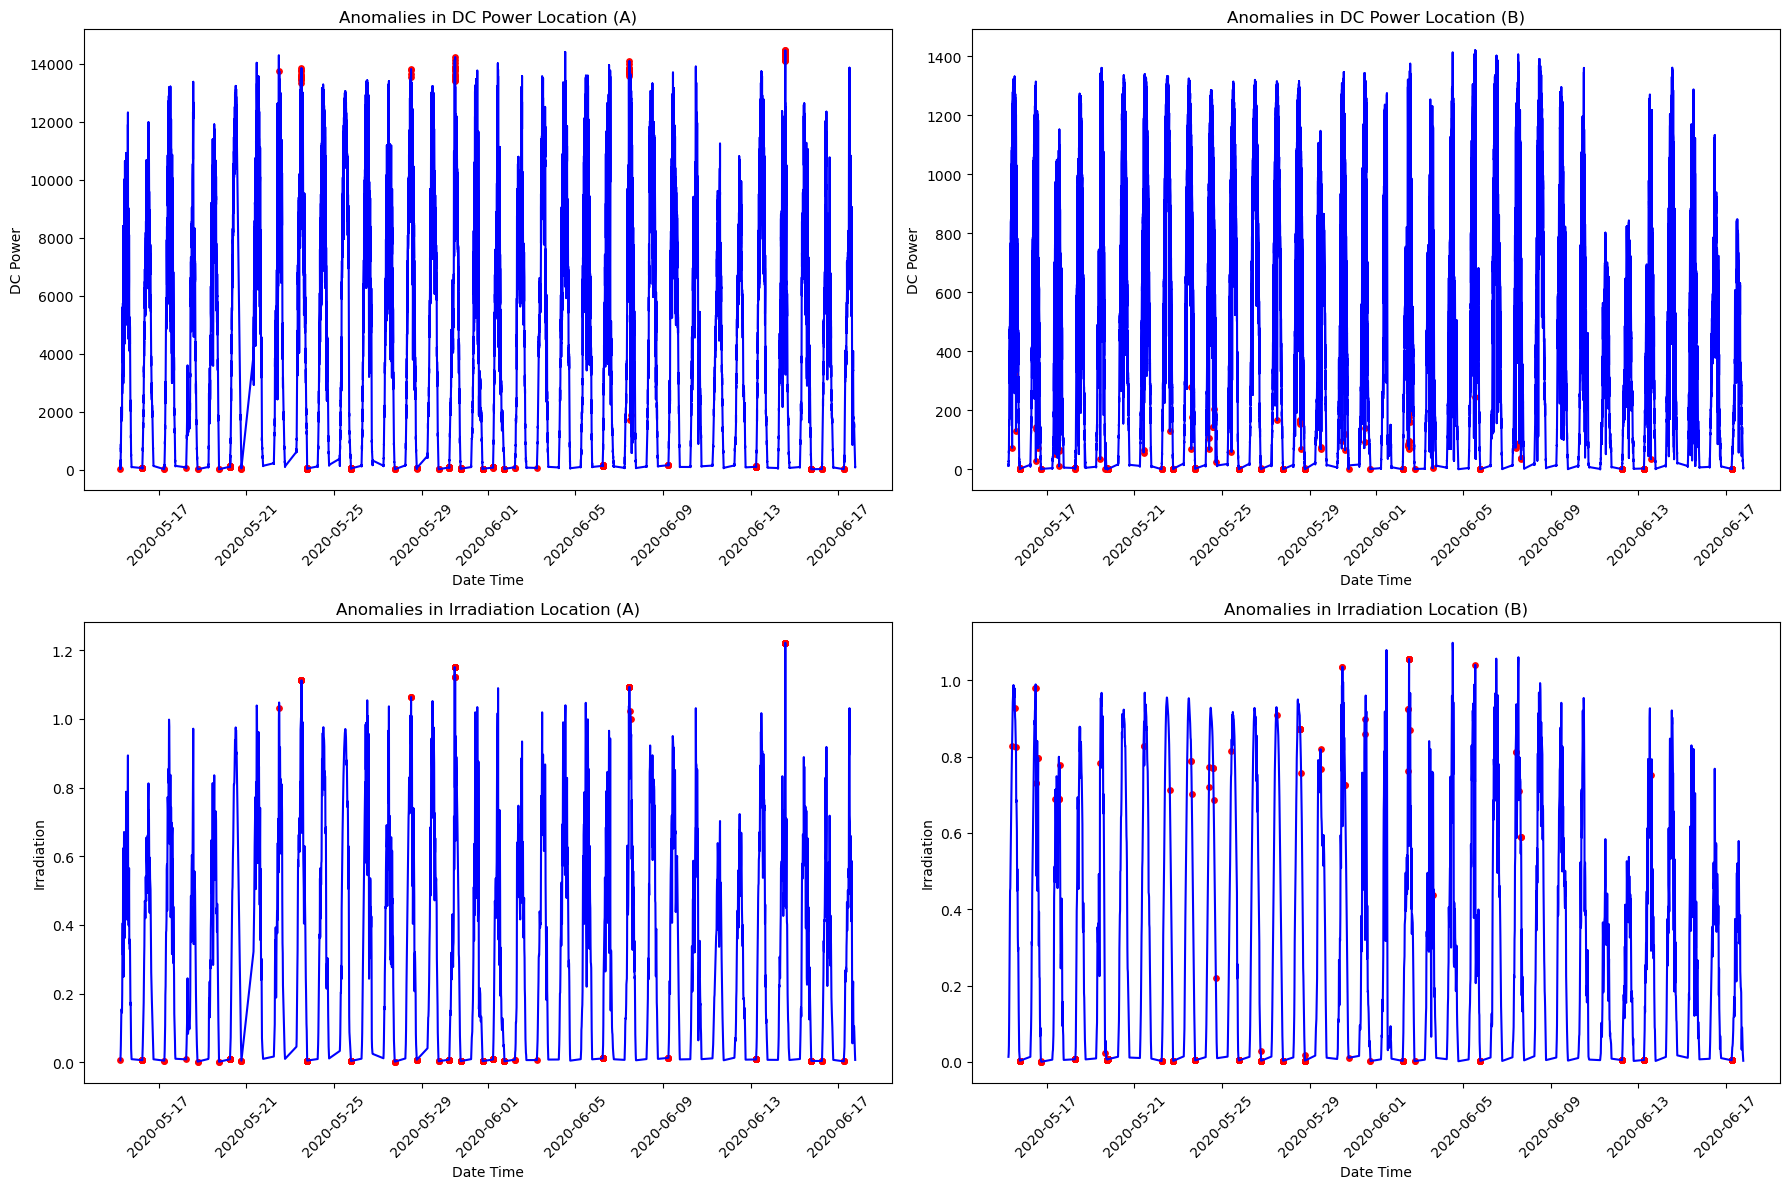

In [179]:
# Creating 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plotting anomalies for merged_A_df_copy['DC_POWER'] (Top-left)
axes[0, 0].plot(merged_A_df_copy['DATE_TIME'], merged_A_df_copy['DC_POWER'], label='DC Power (Original)', color='blue')
axes[0, 0].scatter(merged_A_df_copy['DATE_TIME'][merged_A_df_copy['anomaly']], 
                   merged_A_df_copy['DC_POWER'][merged_A_df_copy['anomaly']], 
                   color='red', label='Anomaly', s=15)
axes[0, 0].set_xlabel('Date Time')
axes[0, 0].set_ylabel('DC Power')
axes[0, 0].set_title('Anomalies in DC Power Location (A)')
axes[0, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees

# Plotting anomalies for merged_B_df_copy['DC_POWER'] (Top-right)
axes[0, 1].plot(merged_B_df_copy['DATE_TIME'], merged_B_df_copy['DC_POWER'], label='DC Power (Original)', color='blue')
axes[0, 1].scatter(merged_B_df_copy['DATE_TIME'][merged_B_df_copy['anomaly']], 
                   merged_B_df_copy['DC_POWER'][merged_B_df_copy['anomaly']], 
                   color='red', label='Anomaly', s=15)
axes[0, 1].set_xlabel('Date Time')
axes[0, 1].set_ylabel('DC Power')
axes[0, 1].set_title('Anomalies in DC Power Location (B)')
axes[0, 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees

# Plotting anomalies for merged_A_df_copy['IRRADIATION'] (Bottom-left)
axes[1, 0].plot(merged_A_df_copy['DATE_TIME'], merged_A_df_copy['IRRADIATION'], label='Irradiation (Original)', color='blue')
axes[1, 0].scatter(merged_A_df_copy['DATE_TIME'][merged_A_df_copy['anomaly']], 
                   merged_A_df_copy['IRRADIATION'][merged_A_df_copy['anomaly']], 
                   color='red', label='Anomaly', s=15)
axes[1, 0].set_xlabel('Date Time')
axes[1, 0].set_ylabel('Irradiation')
axes[1, 0].set_title('Anomalies in Irradiation Location (A)')
axes[1, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees

# Plotting anomalies for merged_B_df_copy['IRRADIATION'] (Bottom-right)
axes[1, 1].plot(merged_B_df_copy['DATE_TIME'], merged_B_df_copy['IRRADIATION'], label='Irradiation (Original)', color='blue')
axes[1, 1].scatter(merged_B_df_copy['DATE_TIME'][merged_B_df_copy['anomaly']], 
                   merged_B_df_copy['IRRADIATION'][merged_B_df_copy['anomaly']], 
                   color='red', label='Anomaly', s=15)
axes[1, 1].set_xlabel('Date Time')
axes[1, 1].set_ylabel('Irradiation')
axes[1, 1].set_title('Anomalies in Irradiation Location (B)')
axes[1, 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees

# Adjust layout for better spacing
plt.tight_layout()

# Displaying the plot
plt.show()


In [180]:
columns_for_detection = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']
data_A= merged_A_df_copy[columns_for_detection]
data_B =merged_B_df_copy[columns_for_detection]

In [181]:
# scales data to a range between 0 and 1 using the MinMaxScaler.
scaler_A = MinMaxScaler(feature_range=(0, 1))
scaler_B = MinMaxScaler(feature_range=(0, 1))
scaled_data_A = scaler_A.fit_transform(data_A)
scaled_data_B = scaler_B.fit_transform(data_B)

In [182]:
# function for creating sequences of a specified length.
def create_sequences_A(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length] 
        sequences.append(seq)
    return np.array(sequences)

def create_sequences_B(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length] 
        sequences.append(seq)
    return np.array(sequences)

seq_length = 30

X = create_sequences_A(scaled_data_A, seq_length)
Y = create_sequences_B(scaled_data_B, seq_length)



In [183]:
# Split the data into training and testing sets, with 80% used for training and 20% for testing.
train_size_A = int(len(X) * 0.8)
train_size_B = int(len(Y) * 0.8)


X_train, X_test = X[:train_size_A], X[train_size_A:]
Y_train, Y_test = Y[:train_size_B], Y[train_size_B:]

In [184]:
# Defines and trains an LSTM model to predict time series data using 50 units and a dense layer with input-output matching.
model_A = Sequential()
model_B = Sequential()

model_A.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_B.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(Y_train.shape[1], Y_train.shape[2])))

model_A.add(Dense(units=X_train.shape[2])) 
model_B.add(Dense(units=Y_train.shape[2])) 

model_A.compile(optimizer='adam', loss='mean_squared_error')
model_B.compile(optimizer='adam', loss='mean_squared_error')

history_A = model_A.fit(X_train, X_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
history_B = model_B.fit(Y_train, Y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20


c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


736/736 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0419 - val_loss: 3.8084e-04
Epoch 2/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3.0553e-04 - val_loss: 1.3791e-04
Epoch 3/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.2236e-04 - val_loss: 6.6631e-05
Epoch 4/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 6.1758e-05 - val_loss: 4.3011e-05
Epoch 5/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3.9688e-05 - val_loss: 3.1530e-05
Epoch 6/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.8600e-05 - val_loss: 2.9876e-05
Epoch 7/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.2213e-05 - val_loss: 1.9316e-05
Epoch 8/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.6789e-05 - val_loss: 1.5127e-05
Epoch 9/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.2143e-05 - val_loss: 1.2344e-05
Epoch 10/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.0634e-05 - val_loss: 9.5687e-06
Epoch 11/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 7.1237e-06 - 

In [194]:
# Generates predictions from the LSTM model, calculates errors, detects anomalies based on a threshold, and marks anomalies in the dataset.
predictions_A = model_A.predict(X_test)
predictions_B = model_B.predict(Y_test)

error_A = np.mean(np.abs(predictions_A - X_test), axis=1)
error_B = np.mean(np.abs(predictions_B - Y_test), axis=1)

threshold_A = np.percentile(error_A, 95)
threshold_B= np.percentile(error_B, 95)
anomalies_A = error_A > threshold_A
anomalies_B = error_B > threshold_B

merged_A_df_copy['anomaly_LSTM'] = 0  
merged_B_df_copy['anomaly_LSTM'] = 0

test_anomalies_indices_A = train_size_A + np.where(anomalies_A)[0] 
test_anomalies_indices_B = train_size_B + np.where(anomalies_B)[0] 

merged_A_df_copy.iloc[test_anomalies_indices_A, merged_A_df_copy.columns.get_loc('anomaly_LSTM')] = 1
merged_B_df_copy.iloc[test_anomalies_indices_B, merged_B_df_copy.columns.get_loc('anomaly_LSTM')] = 1

anomalies_df_A = merged_A_df_copy[merged_A_df_copy['anomaly_LSTM'] == 1]
anomalies_df_B = merged_B_df_copy[merged_B_df_copy['anomaly_LSTM'] == 1]

print(anomalies_df_A[['DATE_TIME', 'DC_POWER', 'anomaly_LSTM']].sample(5))
print("----------------------------------------------------------")
print(anomalies_df_B[['DATE_TIME', 'DC_POWER', 'anomaly_LSTM']].sample(5))

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                DATE_TIME     DC_POWER  anomaly_LSTM
61611 2020-06-14 14:00:00  14312.71429             1
65580 2020-06-16 11:00:00  12263.85714             1
59397 2020-06-13 12:45:00  12373.62500             1
65480 2020-06-16 10:00:00  11391.75000             1
59516 2020-06-13 14:15:00  11796.57143             1
----------------------------------------------------------
                DATE_TIME     DC_POWER  anomaly_LSTM
60120 2020-06-14 09:45:00   586.013333             1
60341 2020-06-14 12:15:00  1185.713333             1
62335 2020-06-15 11:00:00   510.646667             1
60400 2020-06-14 13:00:00  1170.721429             1
58406 2020-06-13 14:15:00   672.740000             1


C:\Users\User\AppData\Local\Temp\ipykernel_5840\2132729247.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_A_df_copy['anomaly_LSTM'] = 0
C:\Users\User\AppData\Local\Temp\ipykernel_5840\2132729247.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_B_df_copy['anomaly_LSTM'] = 0


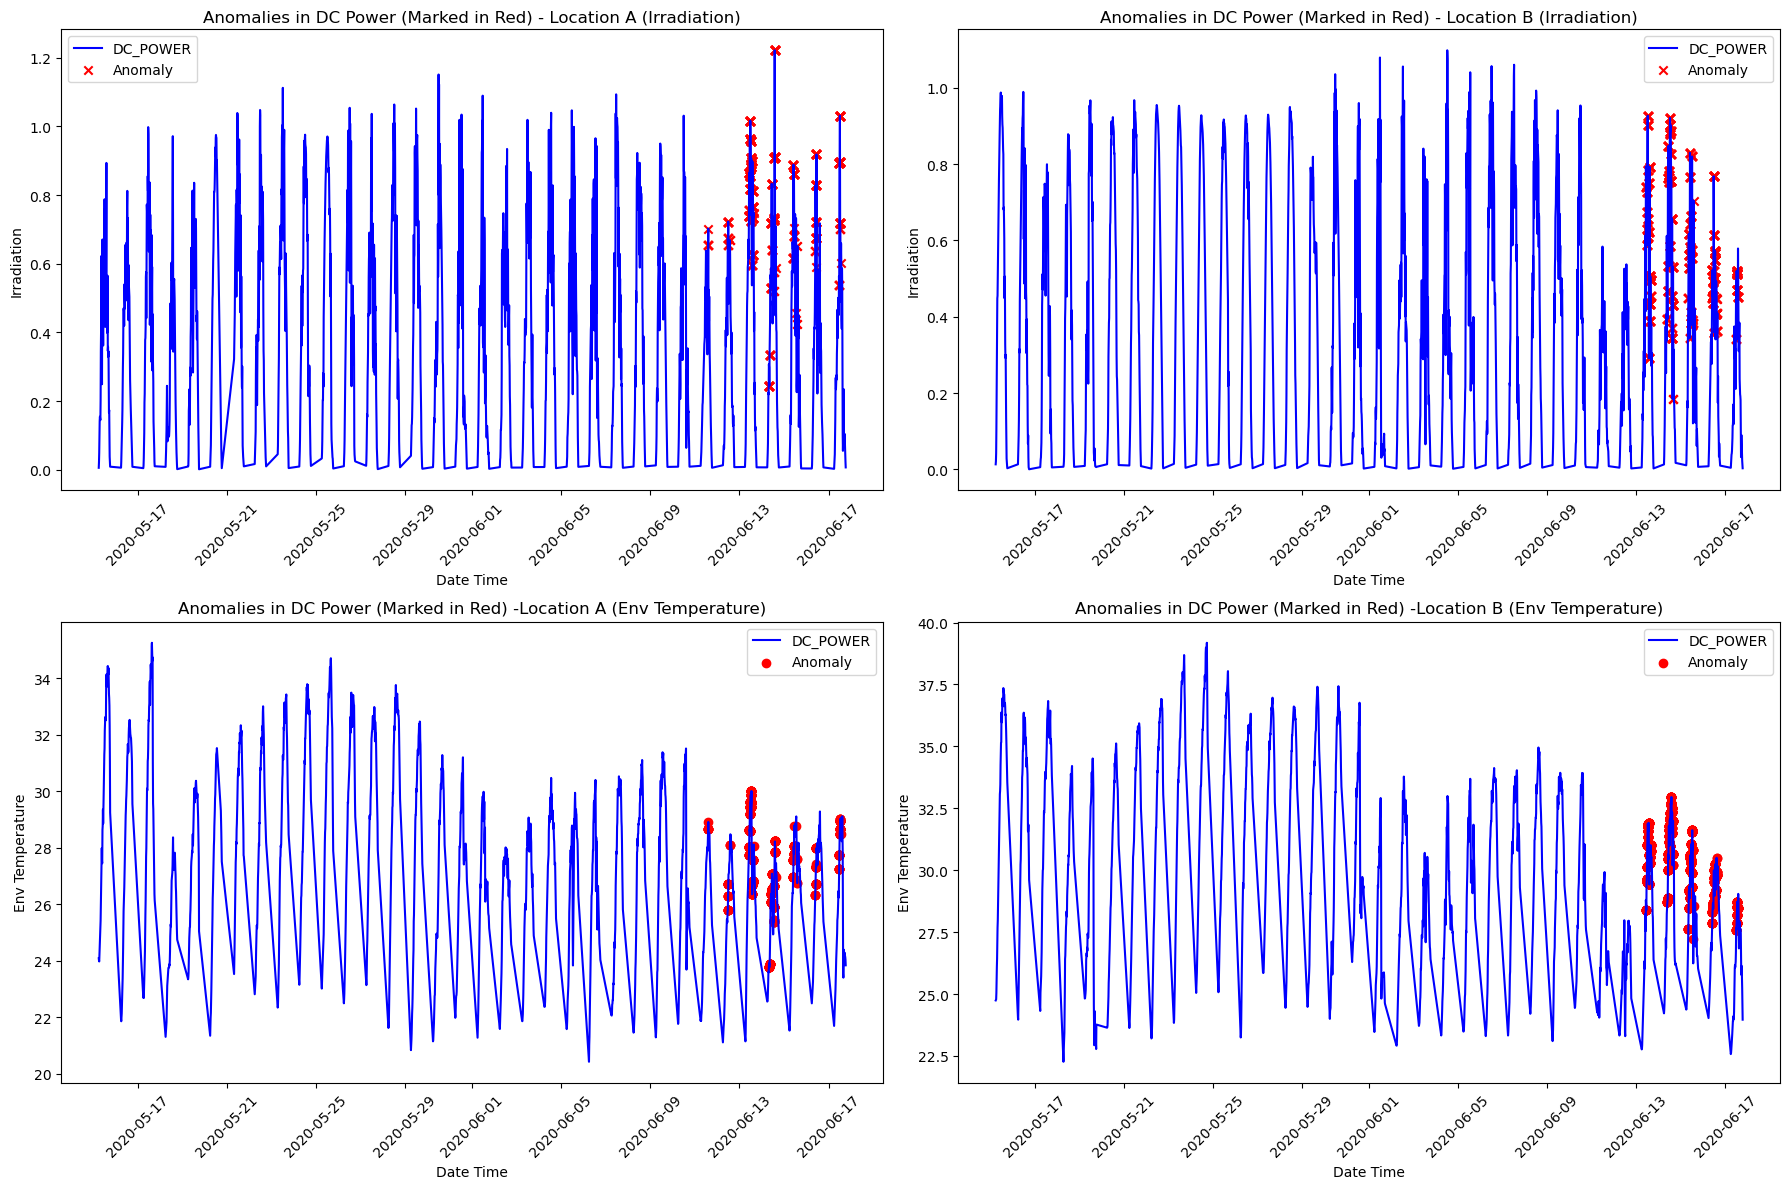

In [199]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plotting for merged_A_df_copy['IRRADIATION'] (Top-left subplot)
axes[0, 0].plot(merged_A_df_copy['DATE_TIME'], merged_A_df_copy['IRRADIATION'], label='DC_POWER', color='blue')
axes[0, 0].scatter(anomalies_df_A['DATE_TIME'], anomalies_df_A['IRRADIATION'], color='red', label='Anomaly', marker='x')
axes[0, 0].set_xlabel('Date Time')
axes[0, 0].set_ylabel('Irradiation')
axes[0, 0].set_title('Anomalies in DC Power (Marked in Red) - Location A (Irradiation)')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees

# Plotting for merged_B_df_copy['IRRADIATION'] (Top-right subplot)
axes[0, 1].plot(merged_B_df_copy['DATE_TIME'], merged_B_df_copy['IRRADIATION'], label='DC_POWER', color='blue')
axes[0, 1].scatter(anomalies_df_B['DATE_TIME'], anomalies_df_B['IRRADIATION'], color='red', label='Anomaly', marker='x')
axes[0, 1].set_xlabel('Date Time')
axes[0, 1].set_ylabel('Irradiation')
axes[0, 1].set_title('Anomalies in DC Power (Marked in Red) - Location B (Irradiation)')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees

# Plotting for merged_A_df_copy['MODULR_TEMPERATURE'] (Bottom-left subplot)
axes[1, 0].plot(merged_A_df_copy['DATE_TIME'], merged_A_df_copy['AMBIENT_TEMPERATURE'], label='DC_POWER', color='blue')
axes[1, 0].scatter(anomalies_df_A['DATE_TIME'], anomalies_df_A['AMBIENT_TEMPERATURE'], color='red', label='Anomaly', marker='o')
axes[1, 0].set_xlabel('Date Time')
axes[1, 0].set_ylabel('Env Temperature')
axes[1, 0].set_title('Anomalies in DC Power (Marked in Red) -Location A (Env Temperature)')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees

# Plotting for merged_B_df_copy['MODULR_TEMPERATURE'] (Bottom-right subplot)
axes[1, 1].plot(merged_B_df_copy['DATE_TIME'], merged_B_df_copy['AMBIENT_TEMPERATURE'], label='DC_POWER', color='blue')
axes[1, 1].scatter(anomalies_df_B['DATE_TIME'], anomalies_df_B['AMBIENT_TEMPERATURE'], color='red', label='Anomaly', marker='o')
axes[1, 1].set_xlabel('Date Time')
axes[1, 1].set_ylabel('Env Temperature')
axes[1, 1].set_title('Anomalies in DC Power (Marked in Red) -Location B (Env Temperature)')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


In [201]:
# Summary statistics of the anomalies.
print(anomalies_df_A['DC_POWER'].describe())
print('--------------------------------------')
print(anomalies_df_B['DC_POWER'].describe())


count      854.000000
mean     10717.955315
std       2066.869728
min       2155.375000
25%       9778.392857
50%      11020.910715
75%      11973.584823
max      14471.125000
Name: DC_POWER, dtype: float64
--------------------------------------
count    1281.000000
mean      795.271733
std       236.831220
min        30.626667
25%       664.640000
50%       779.300000
75%       942.220000
max      1362.060000
Name: DC_POWER, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_5840\2608189453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_A_df_copy['day_of_week'] = merged_A_df_copy['DATE_TIME'].dt.dayofweek
C:\Users\User\AppData\Local\Temp\ipykernel_5840\2608189453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_B_df_copy['day_of_week'] = merged_B_df_copy['DATE_TIME'].dt.dayofweek


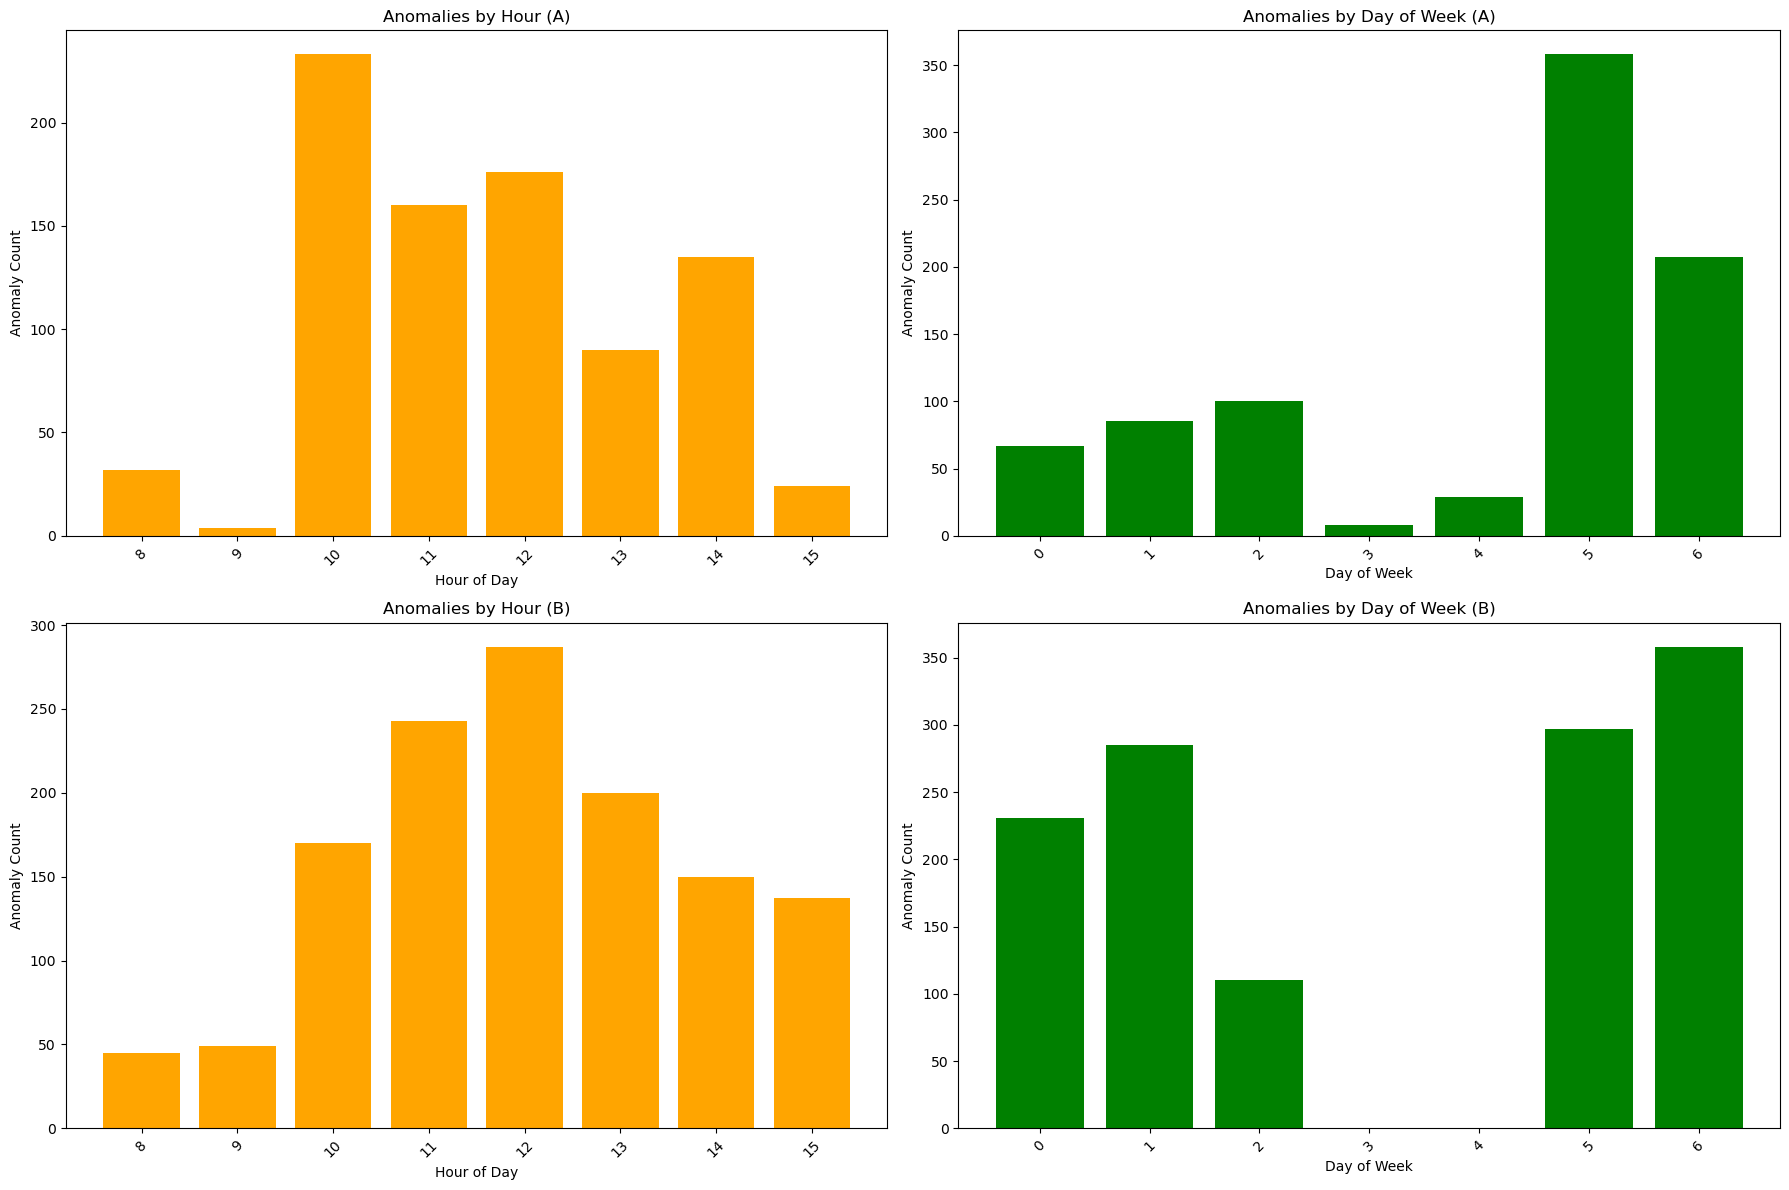

In [209]:

# Add 'day_of_week' column to both DataFrames
merged_A_df_copy['day_of_week'] = merged_A_df_copy['DATE_TIME'].dt.dayofweek
merged_B_df_copy['day_of_week'] = merged_B_df_copy['DATE_TIME'].dt.dayofweek

# Filter anomalies based on the 'anomaly_LSTM' column
anomalies_df_A = merged_A_df_copy[merged_A_df_copy['anomaly_LSTM'] == 1]
anomalies_df_B = merged_B_df_copy[merged_B_df_copy['anomaly_LSTM'] == 1]

# Group anomalies by hour and day of the week for both A and B
hourly_anomalies_A = anomalies_df_A.groupby('HOUR').size()
daily_anomalies_A = anomalies_df_A.groupby('day_of_week').size()

hourly_anomalies_B = anomalies_df_B.groupby('HOUR').size()
daily_anomalies_B = anomalies_df_B.groupby('day_of_week').size()

# Create subplots for both A and B datasets
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot anomalies for A dataset
axes[0, 0].bar(hourly_anomalies_A.index, hourly_anomalies_A.values, color='orange')
axes[0, 0].set_title('Anomalies by Hour (A)')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Anomaly Count')

axes[0, 1].bar(daily_anomalies_A.index, daily_anomalies_A.values, color='green')
axes[0, 1].set_title('Anomalies by Day of Week (A)')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Anomaly Count')

# Plot anomalies for B dataset
axes[1, 0].bar(hourly_anomalies_B.index, hourly_anomalies_B.values, color='orange')
axes[1, 0].set_title('Anomalies by Hour (B)')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Anomaly Count')

axes[1, 1].bar(daily_anomalies_B.index, daily_anomalies_B.values, color='green')
axes[1, 1].set_title('Anomalies by Day of Week (B)')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Anomaly Count')

# Rotate x-axis labels for better visibility
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)


plt.tight_layout()

# Show the plot
plt.show()



In [216]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'DC_POWER' column for both datasets
scaled_data_A = scaler.fit_transform(merged_A_df_copy['DC_POWER'].values.reshape(-1, 1))
scaled_data_B = scaler.fit_transform(merged_B_df_copy['DC_POWER'].values.reshape(-1,1))


In [217]:
def create_sequences_A(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

def create_sequences_B(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):  # Fix loop range
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

# Sequence length for LSTM
seq_length = 50

# Create sequences for both A and B
X = create_sequences_A(scaled_data_A, seq_length)
Y = create_sequences_B(scaled_data_B, seq_length)

In [218]:
train_size_A = int(len(X) * 0.8)
train_size_B = int(len(Y) * 0.8)

X_train, X_test = X[:train_size_A], X[train_size_A:]
Y_train, Y_test = Y[:train_size_B], Y[train_size_B:]

In [220]:
model_A = Sequential()
model_A.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(seq_length, 1)))  # Input shape updated to (seq_length, 1)
model_A.add(MaxPooling1D(pool_size=2))
model_A.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model_A.add(MaxPooling1D(pool_size=2))

model_A.add(LSTM(50, activation='relu', return_sequences=False))  # LSTM for feature extraction
model_A.add(RepeatVector(seq_length))  # Repeat vector for sequence reconstruction
model_A.add(LSTM(50, activation='relu', return_sequences=True))  # LSTM to reconstruct the sequence

# Output layer: Dense with 1 feature per time step (since we're working with single feature sequences)
model_A.add(TimeDistributed(Dense(1)))

model_A.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Build Model B (similar structure to Model A)
model_B = Sequential()
model_B.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(seq_length, 1)))  # Same input shape
model_B.add(MaxPooling1D(pool_size=2))
model_B.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model_B.add(MaxPooling1D(pool_size=2))

model_B.add(LSTM(50, activation='relu', return_sequences=False))  # LSTM for feature extraction
model_B.add(RepeatVector(seq_length))  # Repeat vector for sequence reconstruction
model_B.add(LSTM(50, activation='relu', return_sequences=True))  # LSTM to reconstruct the sequence

# Output layer: Dense with 1 feature per time step
model_B.add(TimeDistributed(Dense(1)))

model_B.compile(optimizer='adam', loss='mean_squared_error')

# Step 6: Fit both models (train the models)
history_A = model_A.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_test, X_test))
history_B = model_B.fit(Y_train, Y_train, epochs=10, batch_size=32, validation_data=(Y_test, Y_test))

# Step 7: Evaluate models (optional, if you want to check performance)
model_A.evaluate(X_test, X_test)
model_B.evaluate(Y_test, Y_test)



Epoch 1/10
920/920 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.0150 - val_loss: 0.0023
Epoch 2/10
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 3/10
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 4/10
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 5/10
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 6/10
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 7/10
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 8/10
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 9/10
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 10/10
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0228 - val_loss: 0.0054
Epoch 2/10
800/800 ━━━━━━━━━━━━

0.0033638207241892815

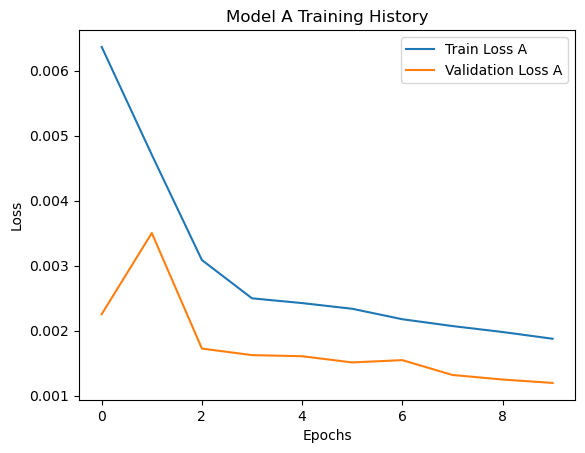

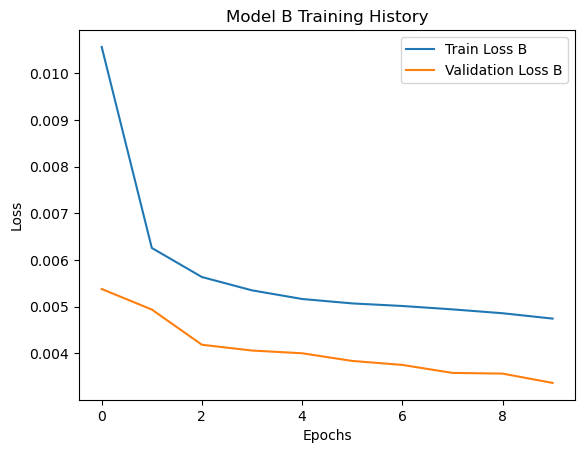

In [221]:
# Plot training history for model A (loss vs epochs)
plt.plot(history_A.history['loss'], label='Train Loss A')
plt.plot(history_A.history['val_loss'], label='Validation Loss A')
plt.title('Model A Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training history for model B (loss vs epochs)
plt.plot(history_B.history['loss'], label='Train Loss B')
plt.plot(history_B.history['val_loss'], label='Validation Loss B')
plt.title('Model B Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [222]:
reconstructed_A = model_A.predict(X_test)
reconstructed_B=model_B.predict(Y_test)

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [223]:
error_A = np.mean(np.abs(reconstructed_A - X_test), axis=1)
error_B = np.mean(np.abs(reconstructed_B - Y_test), axis=1)

threshold_A = np.percentile(error_A, 95)
threshold_B = np.percentile(error_B, 95)

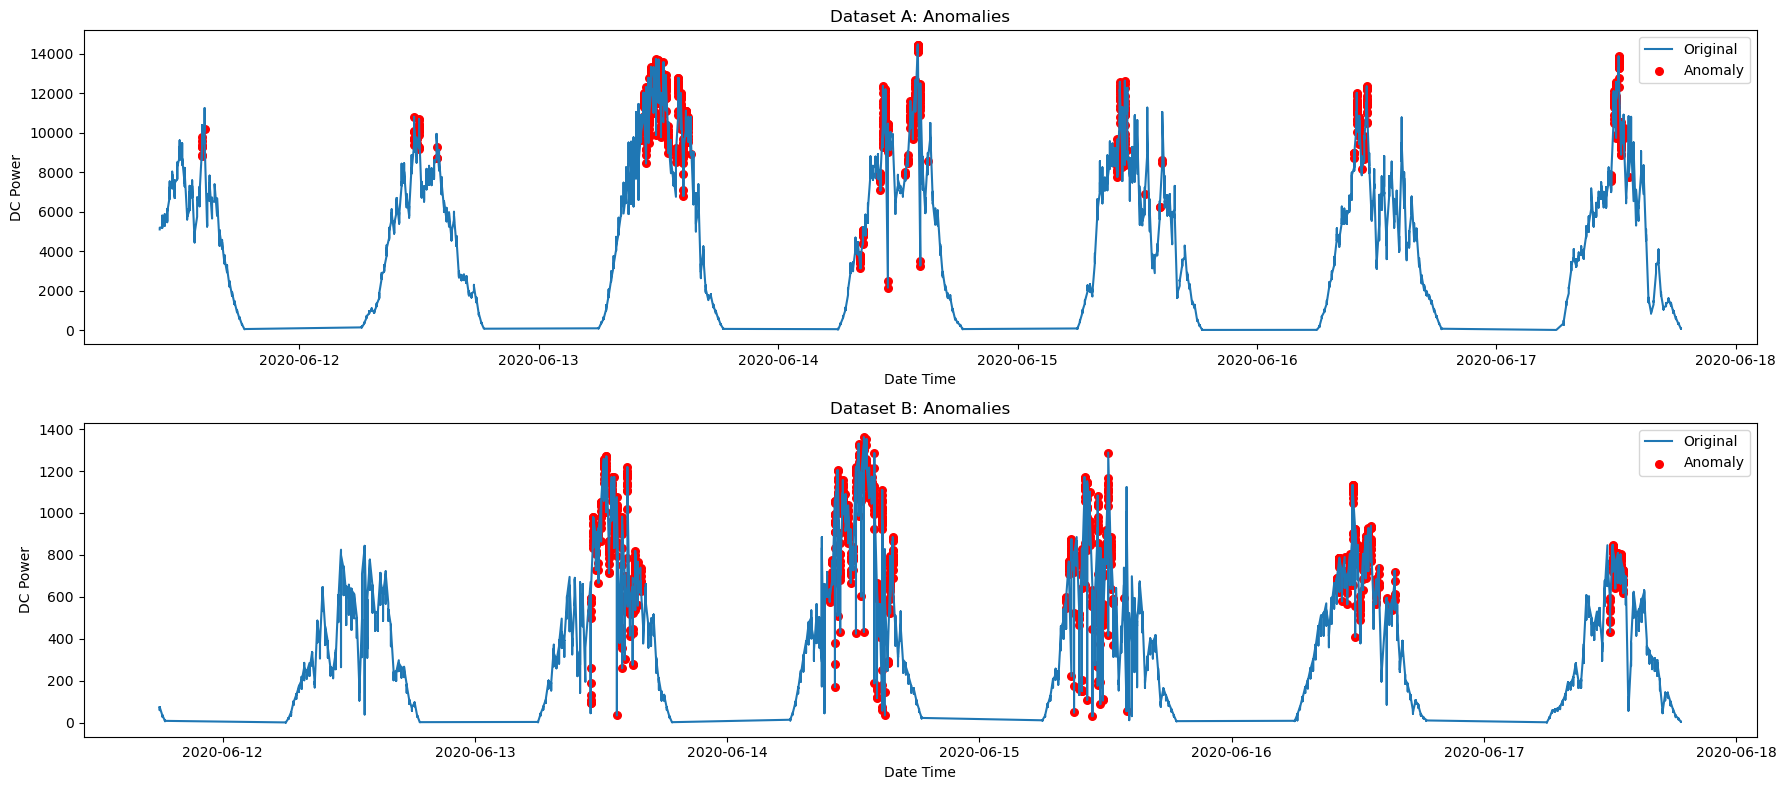

In [227]:

# Identifies anomalies in the dataset by comparing the 'anomaly_LSTM' column
anomalies_A = merged_A_df_copy['anomaly_LSTM'] == 1
anomalies_B = merged_B_df_copy['anomaly_LSTM'] == 1

# Extract the corresponding anomaly dates and power values
anomaly_dates_A = merged_A_df_copy['DATE_TIME'][train_size_A + seq_length:][anomalies_A[train_size_A + seq_length:]]
anomaly_powers_A = merged_A_df_copy['DC_POWER'][train_size_A + seq_length:][anomalies_A[train_size_A + seq_length:]]

anomaly_dates_B = merged_B_df_copy['DATE_TIME'][train_size_B + seq_length:][anomalies_B[train_size_B + seq_length:]]
anomaly_powers_B = merged_B_df_copy['DC_POWER'][train_size_B + seq_length:][anomalies_B[train_size_B + seq_length:]]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 8))  # Create 1 row, 2 columns of subplots

# Plot for dataset A
axes[0].plot(merged_A_df_copy['DATE_TIME'][train_size_A + seq_length:], 
             merged_A_df_copy['DC_POWER'][train_size_A + seq_length:], label='Original')
axes[0].scatter(anomaly_dates_A, anomaly_powers_A, color='red', label='Anomaly', s=30)
axes[0].set_xlabel('Date Time')
axes[0].set_ylabel('DC Power')
axes[0].set_title('Dataset A: Anomalies')
axes[0].legend()

# Plot for dataset B
axes[1].plot(merged_B_df_copy['DATE_TIME'][train_size_B + seq_length:], 
             merged_B_df_copy['DC_POWER'][train_size_B + seq_length:], label='Original')
axes[1].scatter(anomaly_dates_B, anomaly_powers_B, color='red', label='Anomaly', s=30)
axes[1].set_xlabel('Date Time')
axes[1].set_ylabel('DC Power')
axes[1].set_title('Dataset B: Anomalies')
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [231]:
mae_A = mean_absolute_error(X_test.flatten(), reconstructed_A.flatten())
mse_A = mean_squared_error(X_test.flatten(), reconstructed_A.flatten())
mae_B = mean_absolute_error(Y_test.flatten(), reconstructed_B.flatten())
mse_B= mean_squared_error(Y_test.flatten(), reconstructed_B.flatten())


print(f'Mean Absolute Error (MAE) for Location A: {mae_A}')
print(f'Mean Squared Error (MSE) for Location A: {mse_A}')
print('----------------------------------------------------------------------')
print(f'Mean Absolute Error (MAE) for Location B: {mae_B}')
print(f'Mean Squared Error (MSE) for Location B: {mse_B}')

Mean Absolute Error (MAE) for Location A: 0.02165943076702129
Mean Squared Error (MSE) for Location A: 0.0011935671657462127
----------------------------------------------------------------------
Mean Absolute Error (MAE) for Location B: 0.0294030196674324
Mean Squared Error (MSE) for Location B: 0.0033638213654570374
